# Rethinking Statistics course in NumPyro - Week 1

Lecture 1: The Golem of Prague

- [Video](https://youtu.be/cclUd_HoRlo)
- [Slides](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-01)

Lecture 2: Bayesian Inference

- [Video](https://www.youtube.com/watch?v=guTdrfycW2Q&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=2)
- [Slides](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-02)

[Proposed problems](https://github.com/rmcelreath/stat_rethinking_2022/blob/main/homework/week01.pdf) and [solutions in R](https://github.com/rmcelreath/stat_rethinking_2022/blob/main/homework/week01_solutions.pdf) for the exercises of the week.

In [1]:
import os
import arviz as az
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.0.1

sys       : 3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]
jax       : 0.2.10
numpyro   : 0.6.0
matplotlib: 3.3.4
arviz     : 0.11.2

Watermark: 2.2.0



The solutions are largely based on code examples provided by [Du Phan](https://fehiepsi.github.io/rethinking-numpyro/) that accompany the Statistical Rethinking [book](https://xcelab.net/rm/statistical-rethinking/) book.

## Exercise 1

>Suppose the globe tossing data (Chapter 2) had turned out to be 4 water and 11 land. Construct the posterior distribution, using grid approximation. Use the same flat prior as in the book.

In [3]:
water = 4
land = 11
grid_size = 100

# define grid
p_grid = jnp.linspace(start=0, stop=1, num=grid_size)

# define prior
prior = jnp.repeat(1, grid_size)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=water+land, probs=p_grid).log_prob(water))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

Let's plot the posterior distribution

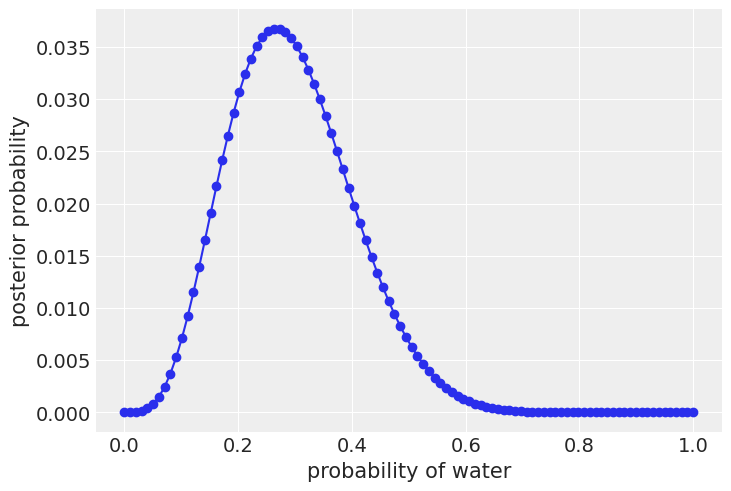

In [4]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.show()

In [28]:
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(0), (10000,))]

In [29]:
jnp.mean(samples)

DeviceArray(0.29539093, dtype=float32)

## Exercise 2

>Now suppose the data are 4 water and 2 land. Compute the posterior again, but this time use a prior that is zero below $p = 0.5$ and a constant above $p = 0.5$. This corresponds to prior information that a majority of the Earth's surface is water.

In [18]:
water = 4
land = 2
grid_size = 100

# define grid
p_grid = jnp.linspace(start=0, stop=1, num=grid_size)

# define prior
new_prior = p_grid > 0.5

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=water+land, probs=p_grid).log_prob(water))

# compute product of likelihood and prior
unstd_posterior_new = likelihood * new_prior

# standardize the posterior, so it sums to 1
posterior_new = unstd_posterior_new / jnp.sum(unstd_posterior_new)

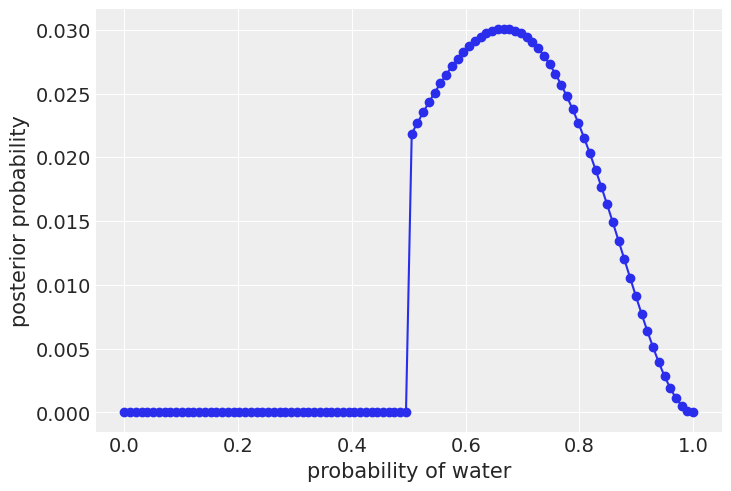

In [20]:
plt.plot(p_grid, posterior_new, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.show()

In [30]:
samples_new = p_grid[dist.Categorical(posterior_new).sample(random.PRNGKey(1), (10000,))]

In [32]:
jnp.mean(samples_new)

DeviceArray(0.6908475, dtype=float32)

## Exercise 3

>For the posterior distribution from 2, compute 89% percentile and HPDI intervals. Compare the widths of these intervals. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution?

In [37]:
a = (100 - 89) / 2
b = 100 - a
jnp.percentile(samples_new, jnp.array([a, b]))

DeviceArray([0.5252525, 0.8787879], dtype=float32)

In [33]:
numpyro.diagnostics.hpdi(samples_new, prob=0.89)

array([0.5050505 , 0.83838385], dtype=float32)

We can see that the percentile interval (the top one) is wider, while the HDPI interval is narrower. HDPI should be narrower and include the point with highest posterior probability. When these intervals are very different, it is better to plot and report the whole posterior distribution to see what is going on.

## Exercise 4

>Suppose there is bias in sampling so that Land is more likely than Water to be recorded. Specifically, assume that 1-in-5 (20%) of Water samples are accidentally recorded instead as ”Land”. First, write a generative simulation of this sampling process. Assuming the true proportion of Water is 0.70, what proportion does your simulation tend to produce instead? Second, using a simulated sample of 20 tosses, compute the unbiased posterior distribution of the true proportion of water.

First, let's see how an unbiased sample would look like

In [128]:
# true proportion of water
p = 0.7

num_tosses = 20
seed = 100
num_samples = 1000

key = random.PRNGKey(seed)
num_waters = dist.Binomial(total_count=num_tosses, probs=p).sample(key, (num_samples,))

In [129]:
jnp.mean(num_waters/num_tosses)

DeviceArray(0.6969, dtype=float32)

<AxesSubplot:>

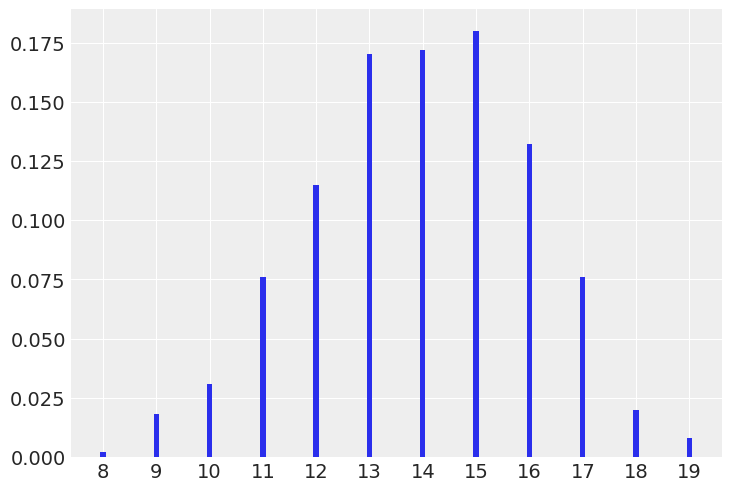

In [130]:
az.plot_dist(num_waters, kind="hist", hist_kwargs={"rwidth": 0.1})

Now let's generate a biased sample

In [104]:
def generate_samples(num_tosses, bias=0.2, seed=100, key=None):
    # true proportion of water
    p = 0.7

    sample = []

    if key is None:
        key = random.PRNGKey(seed)
        
    for i in range(num_tosses):
        key, subkey1, subkey2 = random.split(key, 3)
        sample_i = "L" if random.uniform(subkey1) > p else "W"
        
        if sample_i == "W":
            sample_i = sample_i if random.uniform(subkey2) > bias else "L"
    
        sample.append(sample_i)

    return np.array(sample)

In [105]:
def count_water(sample):
    return sum(sample == "W")

In [131]:
num_tosses = 20
num_samples = 1000
key = random.PRNGKey(101)
keys = random.split(key, num_samples)

num_waters = []
for i in range(num_samples):
    sample = generate_samples(num_tosses, bias=0.2, key=keys[i])
    water = count_water(sample)
    num_waters.append(water)

In [133]:
np.mean(np.array(num_waters)/num_tosses)

0.5619000000000001

<AxesSubplot:>

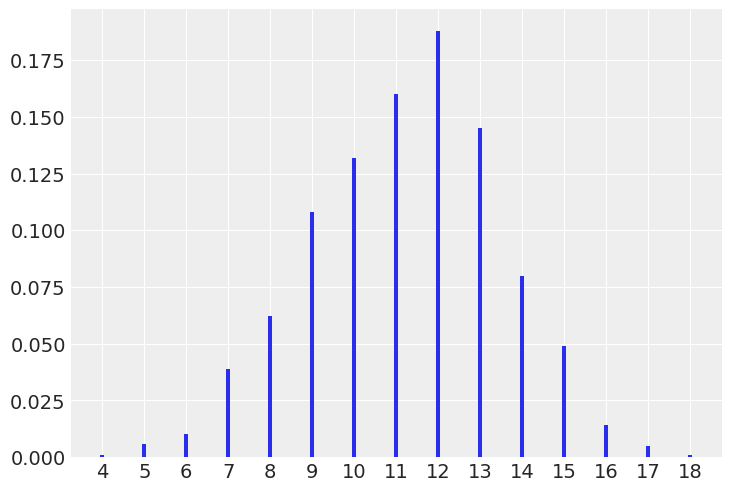

In [134]:
az.plot_dist(num_waters, kind="hist", hist_kwargs={"rwidth": 0.1})

The same can be more succintly and efficiently computed as follows

In [136]:
# true proportion of water
p = 0.7

# sampling bias
bias = 0.2

num_tosses = 20
seed = 100
num_samples = 1000

key = random.PRNGKey(seed)
key, subkey = random.split(key)
num_waters_unbiased = dist.Binomial(total_count=num_tosses, probs=p).sample(key, (num_samples,))
num_waters = dist.Binomial(total_count=num_waters_unbiased, probs=(1-bias)).sample(subkey, (num_samples,))

In [137]:
jnp.mean(num_waters/num_tosses)

DeviceArray(0.5615212, dtype=float32)

In one step, the biased proportion of water can be computed as $p\times(1-bias)$. Let's check

In [141]:
# true proportion of water
p = 0.7

# sampling bias
bias = 0.2

num_tosses = 20
seed = 100
num_samples = 1000

key = random.PRNGKey(seed)
num_waters = dist.Binomial(total_count=num_tosses, probs=p*(1-bias)).sample(key, (num_samples,))

jnp.mean(num_waters/num_tosses)

DeviceArray(0.55514985, dtype=float32)

Finally, let's compute an unbiased posterior distribution

In [114]:
num_tosses = 20

In [173]:
sample = generate_samples(num_tosses, bias=0.2, seed=102)
print(sample)

['W' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'W'
 'W' 'L']


In [174]:
water = count_water(sample)
# Alternatively:
# water = dist.Binomial(total_count=num_tosses, probs=p*(1-bias)).sample(random.PRNGKey(105), (1,))

grid_size = 100

# define grid
p_grid = jnp.linspace(start=0, stop=1, num=grid_size)

# define prior
prior = jnp.repeat(1, grid_size)

# compute likelihood at each value in grid
likelihood_biased = jnp.exp(dist.Binomial(total_count=num_tosses, probs=p_grid).log_prob(water))
# account for the sampling bias
likelihood_unbiased = jnp.exp(dist.Binomial(total_count=num_tosses, probs=p_grid*(1-bias)).log_prob(water))

# compute product of likelihood and prior
unstd_posterior_biased = likelihood_biased * prior
unstd_posterior_unbiased = likelihood_unbiased * prior

# standardize the posterior, so it sums to 1
posterior_biased = unstd_posterior_biased / jnp.sum(unstd_posterior_biased)
posterior_unbiased = unstd_posterior_unbiased / jnp.sum(unstd_posterior_unbiased)

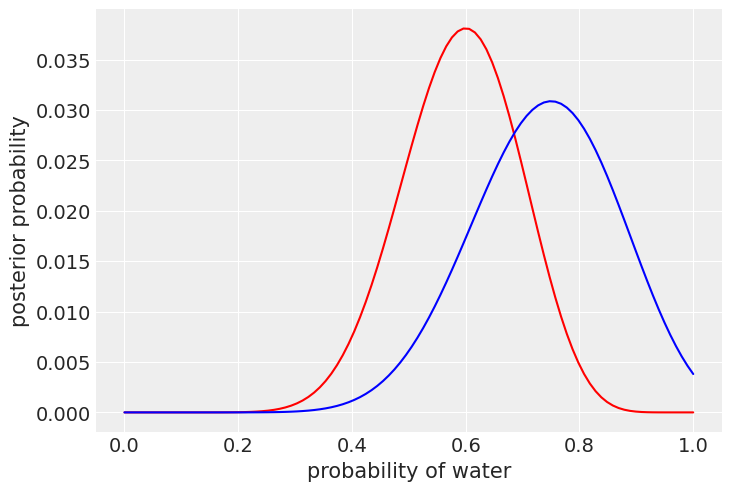

In [175]:
plt.plot(p_grid, posterior_biased, color="red")
plt.plot(p_grid, posterior_unbiased, color="blue")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.show()